In [1]:
# !nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# imports
import torch
from torch.utils.data import DataLoader

In [3]:
# unpickle function -> from https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# some variables
DATA_FOLDER = './data/'
C_FOLDER = 'cifar-10-batches-py/'
torch.manual_seed(20)
device = 'cpu'

In [5]:
import urllib.request
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
urlopen = urllib.request.urlopen('https://www.cs.toronto.edu/~kriz/cifar.html')

In [6]:
from torchvision import datasets, transforms

# getting the training and testing data
training_data = datasets.CIFAR10(DATA_FOLDER, download=True, train=True, transform=transforms.ToTensor())
testing_data = datasets.CIFAR10(DATA_FOLDER, download=False, train=False, transform=transforms.ToTensor())

# unpickling the text labels
batches_labels = unpickle(DATA_FOLDER + C_FOLDER + 'batches.meta')[b'label_names']

Files already downloaded and verified


In [7]:
# data loaders
training_set = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=False)
testing_set = DataLoader(testing_data, batch_size=64, shuffle=False, num_workers=2, pin_memory=False)

In [8]:
# get label name
def get_label(i):
    return batches_labels[i].decode('ascii')

# visualize images -> given a tensor of shape 3072 | 32 x 32 x 3
import matplotlib.pyplot as plt
def visual_img(img):
    img = img.view(3,32,32)
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)
    plt.imshow(img)
    plt.show()

Simple Interconnected Neural Network

In [9]:
# the neural network
import torch.nn as nn
from torch.nn.functional import relu, log_softmax, nll_loss
import torch.optim as optim

# the network
class Network(nn.Module):

    def __init__(self):
        super().__init__()
        self.hl1 = nn.Linear(32*32*3, 128)
        self.hl2 = nn.Linear(128, 64)
        self.hl3 = nn.Linear(64, 64)
        self.hl4 = nn.Linear(64, 10)

    def forward(self, target):
        target = relu(self.hl1(target))
        target = relu(self.hl2(target))
        target = relu(self.hl3(target))
        target = log_softmax(self.hl4(target), dim=1)
        return target

# the network and optmizer
network = Network()
network.to(device, non_blocking=True)
optimizer = optim.Adam(network.parameters(), lr=0.001)

Training

In [10]:
from tqdm import tqdm

# training the neural network
training_accuracies = []
losses = []

for gen in tqdm(range(10)):
    epoch_loss = []
    epoch_accuracies = 0
    for idx, batch in enumerate(training_set):

        # getting the images and labels from each batch
        images, target = batch

        # resetting the gradient to zero
        optimizer.zero_grad()

        # inputting the images into the network and calculating the accuracies over period
        output = network(images.view(-1,32*32*3).to(device, non_blocking=True))
        for p, l in zip(output, target):
            if torch.argmax(p) == l:
                epoch_accuracies += 1
        
        # loss and adding them to losses
        loss = nn.CrossEntropyLoss()
        loss = loss(output, target.to(device, non_blocking=True))
        loss.backward()
        epoch_loss.append(loss.item())

        # forward and appending training_results
        optimizer.step()

    training_accuracies.append(epoch_accuracies/50000)
    losses.append(sum(epoch_loss) / len(epoch_loss))

100%|██████████| 10/10 [01:58<00:00, 11.89s/it]


Testing

In [11]:
y_test = []
y_pred = []
correct_predictions = 0

with torch.no_grad():
    for batch in testing_set:
        images, labels = batch
        output = network(images.view(-1,32*32*3).to(device, non_blocking=True))
        
        for pred, label in zip(output, labels):
            pred = torch.Tensor.cpu(torch.argmax(pred))
            y_test.append(label)
            y_pred.append(pred)
            if pred == label:
                correct_predictions += 1

test_accuracy = correct_predictions/10000
print(test_accuracy*100, '%', 'on test set.')

45.93 % on test set.


Training Accuracies and Losses

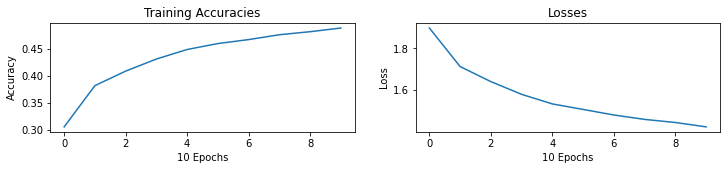

0.4891 end accuracy | 1.4255284008467595 end loss.


In [12]:
import matplotlib.pyplot as plt

# setup
fig, ax = plt.subplots(1, 2, figsize=(12, 2))

ax[0].plot(training_accuracies)
ax[0].set_title('Training Accuracies')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel(f'{len(training_accuracies)} Epochs')

ax[1].plot(losses)
ax[1].set_title('Losses')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel(f'{len(training_accuracies)} Epochs')

# display
plt.show()

# finish
print(training_accuracies[-1], 'end accuracy |', losses[-1], 'end loss.')

Metrics

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.64      0.51      1000
           1       0.69      0.39      0.50      1000
           2       0.33      0.43      0.37      1000
           3       0.34      0.22      0.27      1000
           4       0.47      0.29      0.36      1000
           5       0.46      0.30      0.37      1000
           6       0.45      0.63      0.52      1000
           7       0.54      0.51      0.52      1000
           8       0.48      0.71      0.57      1000
           9       0.53      0.48      0.50      1000

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.45     10000
weighted avg       0.47      0.46      0.45     10000



Precision Bar

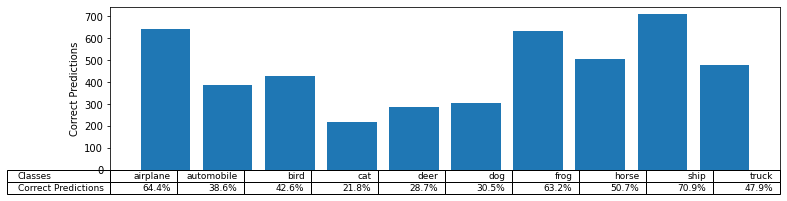

In [14]:
# precision
p_amt = [0 for i in range(10)]
for l, p in zip(y_test, y_pred):
    if l == p:
        p_amt[l] += 1
fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(range(10), p_amt)
ax.set_xticks([])
ax.set_ylabel('Correct Predictions')
ax.table(cellText=(([get_label(i) for i in range(10)], [f'{p/10}%' for p in p_amt])), rowLabels=['Classes', 'Correct Predictions'], loc='bottom')

# display
plt.show()

# Improved Neural Network
Implements Convolution

In [15]:
from torch.nn.functional import max_pool2d

# the network
class ImprovedNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        # convolution
        self.conv1 = nn.Conv2d(3, 50, 3)
        self.conv2 = nn.Conv2d(50, 100, 3)
        self.conv3 = nn.Conv2d(100, 100, 3)

        # interconnected
        self.l1 = nn.Linear(400, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 10)

        # dropout
        self.dropout = nn.Dropout(0.3)

    def forward(self, target):
        target = max_pool2d(relu(self.conv1(target)), 2)
        target = max_pool2d(relu(self.conv2(target)), 2)
        target = max_pool2d(relu(self.conv3(target)), 2)

        target = torch.flatten(target, 1)
        target = self.dropout(target)

        target = relu(self.l1(target))
        target = relu(self.l2(target))
        target = relu(self.l3(target))
        target = self.out(target)
        return target

# the network and optimizer
improved_net = ImprovedNetwork()
improved_net.to(device)
optimizer = optim.Adam(improved_net.parameters(), lr=0.001)

Training

In [16]:
# training the neural network
training_accuracies = []
losses = []

for gen in tqdm(range(40)):
    epoch_loss = []
    epoch_accuracies = 0
    for batch in training_set:

        # getting the images and labels from each batch
        images, target = batch

        # resetting the gradient to zero
        optimizer.zero_grad()

        # inputting the images into the network and calculating the accuracies over period
        output = improved_net(images.view(-1, 3, 32, 32).to(device, non_blocking=True))
        for p, l in zip(output, target):
            if torch.argmax(p) == l:
                epoch_accuracies += 1

        # loss
        loss = nn.CrossEntropyLoss()
        loss = loss(output, target.to(device, non_blocking=True))
        loss.backward()
        epoch_loss.append(loss.item())

        # forward
        optimizer.step()

    training_accuracies.append(epoch_accuracies/50000)
    losses.append(sum(epoch_loss) / len(epoch_loss))

100%|██████████| 40/40 [1:06:39<00:00, 99.99s/it] 


Testing

In [17]:
y_test = []
y_pred = []
correct_predictions = 0

with torch.no_grad():
    for batch in testing_set:
        images, labels = batch
        output = improved_net(images.view(-1, 3, 32, 32).to(device))
        
        for pred, label in zip(output, labels):
            pred = torch.Tensor.cpu(torch.argmax(pred))
            y_test.append(label)
            y_pred.append(pred)
            if pred == label:
                correct_predictions += 1

test_accuracy = correct_predictions/10000
print(test_accuracy*100, '%', 'on test set.')

68.42 % on test set.


Training Accuracies and Losses

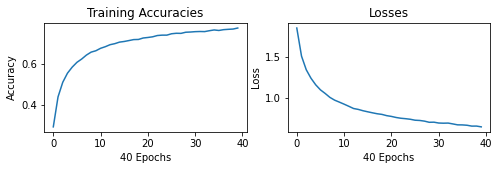

0.77536 end accuracy | 0.6362296350852913 end loss.


In [18]:
import matplotlib.pyplot as plt

# setup
fig, ax = plt.subplots(1, 2, figsize=(8, 2))

ax[0].plot(training_accuracies)
ax[0].set_title('Training Accuracies')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel(f'{len(training_accuracies)} Epochs')

ax[1].plot(losses)
ax[1].set_title('Losses')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel(f'{len(training_accuracies)} Epochs')

# display
plt.show()

# finish
print(training_accuracies[-1], 'end accuracy |', losses[-1], 'end loss.')

Classification Report

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1000
           1       0.85      0.81      0.83      1000
           2       0.62      0.51      0.56      1000
           3       0.51      0.50      0.50      1000
           4       0.62      0.66      0.64      1000
           5       0.57      0.63      0.60      1000
           6       0.78      0.73      0.75      1000
           7       0.67      0.75      0.71      1000
           8       0.76      0.79      0.77      1000
           9       0.80      0.73      0.76      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



Precision Bar

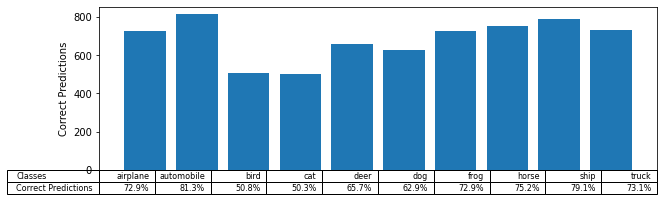

In [20]:
# precision
p_amt = [0 for i in range(10)]
for l, p in zip(y_test, y_pred):
    if l == p:
        p_amt[l] += 1
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(range(10), p_amt)
ax.set_xticks([])
ax.set_ylabel('Correct Predictions')
ax.table(cellText=(([get_label(i) for i in range(10)], [f'{p/10}%' for p in p_amt])), rowLabels=['Classes', 'Correct Predictions'], loc='bottom')

# display
plt.show()